### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 4
### Due: Friday, Feb 21st at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution 1

#### Part 1

In [1]:
import numpy as np

def hetero_mean(x_i, sigma):

    return np.sum(x_i/(sigma**2))/np.sum(1/(sigma**2))

def hetero_std_mean(sigma):

    return np.sqrt(1/np.sum(1/(sigma**2)))

    
data = np.load('../../../homeworks/hw_data/hw4_data_1.npy')

voltage = data[:,0]
voltage_uncertainty = data[:,1]

voltage_mean = hetero_mean(voltage, voltage_uncertainty)
voltage_mean_uncertainty = hetero_std_mean(voltage_uncertainty)

print("The mean:                   %.5f" % voltage_mean)
print("The standard error on mean: %.5f" % voltage_mean_uncertainty)

The mean:                   4.94212
The standard error on mean: 0.43024


#### Part 2

In [2]:
from scipy import optimize

def ln_lik_hetero_gauss(mu, sigma, x_i):

    return np.log(2*np.pi*(sigma**2)) + (((x_i - mu)**2) / (sigma**2))

trial_gauss = [np.mean(voltage), np.std(voltage)]

f_gauss = lambda t: np.sum(ln_lik_hetero_gauss(t[0], t[1], x_i=voltage))

beta_gauss = optimize.fmin(f_gauss, trial_gauss)

print("The best fit mean: %.5f" % beta_gauss[0])

Optimization terminated successfully.
         Current function value: 28.079373
         Iterations: 23
         Function evaluations: 46
The best fit mean: 5.10600


#### Part 3

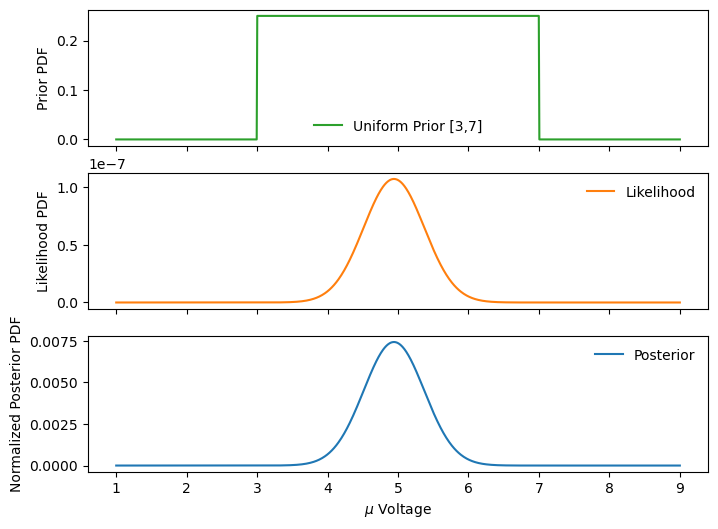

In [3]:
import scipy.stats as stat
import matplotlib.pyplot as plt

def prior_funct(mean, part3_prior=False, part5_prior=False, part6_prior=False, part8_prior=False):
    
    if part8_prior:
        if round(mean,2)==round(beta_gauss[0],2):
            return 1
        else:
            return 0
    
    if part6_prior:
        mu = 6
        sigma = 0.3
        return (1/np.sqrt(2*np.pi*(sigma**2))) * np.exp(-((mean-mu)**2)/(2*(sigma**2)))
        
    elif part5_prior:
        if mean>=4.6 and mean<=5.4:
            return 1/(5.4-4.6)
        else:
            return 0 

    elif part3_prior:
        if mean>=3 and mean<=7:
            return 1/(7-3)
        else:
            return 0

    else:
        raise ValueError("Specify which part's prior to use in the argument of function call!!!")
            

def likelihood_funct(mean, x_i, sigma):
    return np.prod((1/np.sqrt(2*np.pi*(sigma**2))) * np.exp(-((x_i-mean)**2)/(2*(sigma**2))))

mgrid = np.linspace(1, 9, 1000)

prior = [prior_funct(m, part3_prior=True) for m in mgrid]
likelihood = [likelihood_funct(m, voltage, voltage_uncertainty) for m in mgrid]
post = [likelihood_funct(m, voltage, voltage_uncertainty) * prior_funct(m, part3_prior=True) for m in mgrid]
post_norm = post/np.sum(post)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)

ax[0].plot(mgrid, prior, label='Uniform Prior [3,7]', color='tab:green')
ax[0].legend(frameon=False)
ax[0].set_ylabel('Prior PDF')

ax[1].plot(mgrid, likelihood, label='Likelihood', color='tab:orange')
ax[1].legend(frameon=False)
ax[1].set_ylabel('Likelihood PDF')

ax[2].plot(mgrid, post_norm, label='Posterior', color='tab:blue')
ax[2].legend(frameon=False)
ax[2].set_xlabel(r'$\mu$ Voltage')
ax[2].set_ylabel('Normalized Posterior PDF')
#plt.plot(mgrid, prior)

plt.show()

#### Part 4

For Part 3              Lower Bound          Upper Bound
68.3% credible region:  4.515515515515515    5.364364364364365
Sample Mean ± error:    4.511874868373253    5.372361560477355
 
MAP:  4.93993993993994


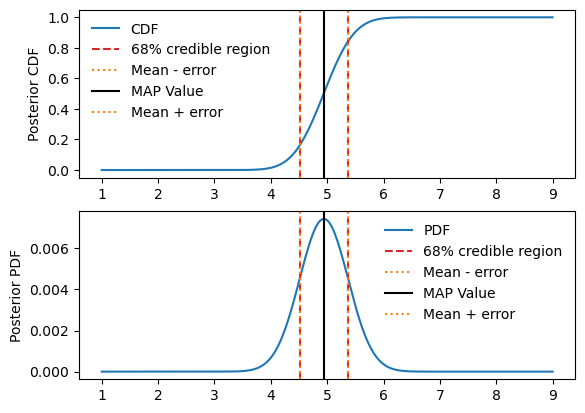

In [4]:
# CDF and sorted
def create_cdf(pdf, sort=False):
    
    if sort:
        return np.sort(np.cumsum(pdf))
    else:
        return np.cumsum(pdf)# * (mgrid[1]-mgrid[0])


# Cal credible region. cr - Credible region
def get_cred_region(cr, cdf, xgrid):
    
    # Quantile range for given cr
    quant_range = [(1-cr)/2, (1+cr)/2]

    # Condition to compare cdf prob with the quantile boundaries and getting the lower and upper bound from the corresponding mgrid
    cond = [cdf>quant_range[0], cdf<quant_range[1]]

    lb, up = xgrid[cond[0]], xgrid[cond[1]]
    
    return lb[0], up[-1]


cdf_sorted = create_cdf(pdf=post_norm, sort=True)
lower_bound, upper_bound = get_cred_region(cr=0.683, cdf=cdf_sorted, xgrid=mgrid)


# MAP
map_value = mgrid[np.argmax(post_norm)]

print("For Part 3              Lower Bound", "         Upper Bound")
print("68.3% credible region: ", lower_bound, "  ", upper_bound)
print("Sample Mean ± error:   ", voltage_mean-voltage_mean_uncertainty, "  ", voltage_mean+voltage_mean_uncertainty)
print(" ")
print("MAP: ", map_value)

fig, [ax, ax1] = plt.subplots(nrows=2, ncols=1)

ax.plot(mgrid, cdf_sorted, label='CDF', color='tab:blue')
ax.axvline(lower_bound, color='tab:red', ls='--', label=r'68% credible region')
ax.axvline(voltage_mean-voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean - error')
ax.axvline(map_value, color='black', label='MAP Value')
ax.axvline(upper_bound, color='tab:red', ls='--')
ax.axvline(voltage_mean+voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean + error')
ax.legend(frameon=False)
ax.set_ylabel('Posterior CDF')

ax1.plot(mgrid, post_norm, label='PDF', color='tab:blue')
ax1.axvline(lower_bound, color='tab:red', ls='--', label=r'68% credible region')
ax1.axvline(voltage_mean-voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean - error')
ax1.axvline(map_value, color='black', label='MAP Value')
ax1.axvline(upper_bound, color='tab:red', ls='--')
ax1.axvline(voltage_mean+voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean + error')
ax1.legend(frameon=False)
ax1.set_ylabel('Posterior PDF')

plt.show()

#### Part 5

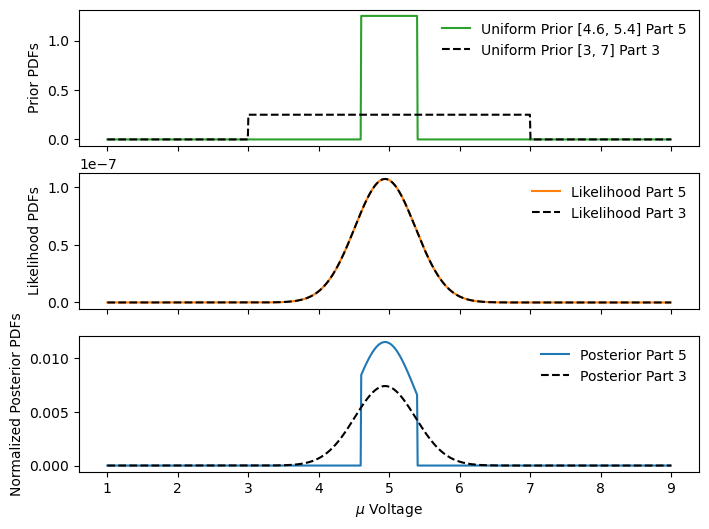

For Part 5              Lower Bound          Upper Bound
68.3% credible region:  4.731731731731731    5.228228228228228
Sample Mean ± error:    4.511874868373253    5.372361560477355
 
MAP:  4.93993993993994


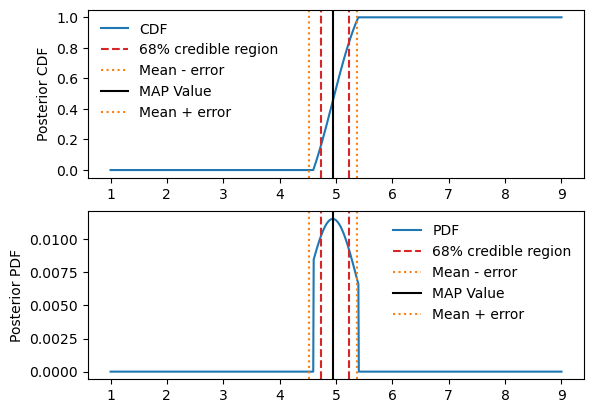

In [6]:
prior_p5 = [prior_funct(m, part5_prior=True) for m in mgrid]
likelihood_p5 = likelihood
post_p5 = [likelihood_funct(m, voltage, voltage_uncertainty) * prior_funct(m, part5_prior=True) for m in mgrid]
post_norm_p5 = post_p5/np.sum(post_p5)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)

ax[0].plot(mgrid, prior_p5, label='Uniform Prior [4.6, 5.4] Part 5', color='tab:green')
ax[0].plot(mgrid, prior, label='Uniform Prior [3, 7] Part 3', color='black', ls='--')
ax[0].legend(frameon=False)
ax[0].set_ylabel('Prior PDFs')

ax[1].plot(mgrid, likelihood_p5, label='Likelihood Part 5', color='tab:orange')
ax[1].plot(mgrid, likelihood, label='Likelihood Part 3', color='black', ls='--')
ax[1].legend(frameon=False)
ax[1].set_ylabel('Likelihood PDFs')

ax[2].plot(mgrid, post_norm_p5, label='Posterior Part 5', color='tab:blue')
ax[2].plot(mgrid, post_norm, label='Posterior Part 3', color='black', ls='--')
ax[2].legend(frameon=False)
ax[2].set_xlabel(r'$\mu$ Voltage')
ax[2].set_ylabel('Normalized Posterior PDFs')
#plt.plot(mgrid, prior)

plt.show()


###########################################################################


cdf_sorted_p5 = create_cdf(pdf=post_norm_p5, sort=True)
lower_bound_p5, upper_bound_p5 = get_cred_region(cr=0.683, cdf=cdf_sorted_p5, xgrid=mgrid)

# MAP
map_value_p5 = mgrid[np.argmax(post_norm_p5)]

print("For Part 5              Lower Bound", "         Upper Bound")
print("68.3% credible region: ", lower_bound_p5, "  ", upper_bound_p5)
print("Sample Mean ± error:   ", voltage_mean-voltage_mean_uncertainty, "  ", voltage_mean+voltage_mean_uncertainty)
print(" ")
print("MAP: ", map_value_p5)


fig, [ax, ax1] = plt.subplots(nrows=2, ncols=1)

ax.plot(mgrid, cdf_sorted_p5, label='CDF', color='tab:blue')
ax.axvline(lower_bound_p5, color='tab:red', ls='--', label=r'68% credible region')
ax.axvline(voltage_mean-voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean - error')
ax.axvline(map_value_p5, color='black', label='MAP Value')
ax.axvline(upper_bound_p5, color='tab:red', ls='--')
ax.axvline(voltage_mean+voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean + error')
ax.legend(frameon=False)
ax.set_ylabel('Posterior CDF')

ax1.plot(mgrid, post_norm_p5, label='PDF', color='tab:blue')
ax1.axvline(lower_bound_p5, color='tab:red', ls='--', label=r'68% credible region')
ax1.axvline(voltage_mean-voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean - error')
ax1.axvline(map_value_p5, color='black', label='MAP Value')
ax1.axvline(upper_bound_p5, color='tab:red', ls='--')
ax1.axvline(voltage_mean+voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean + error')
ax1.legend(frameon=False)
ax1.set_ylabel('Posterior PDF')

plt.show()

#### Part 6

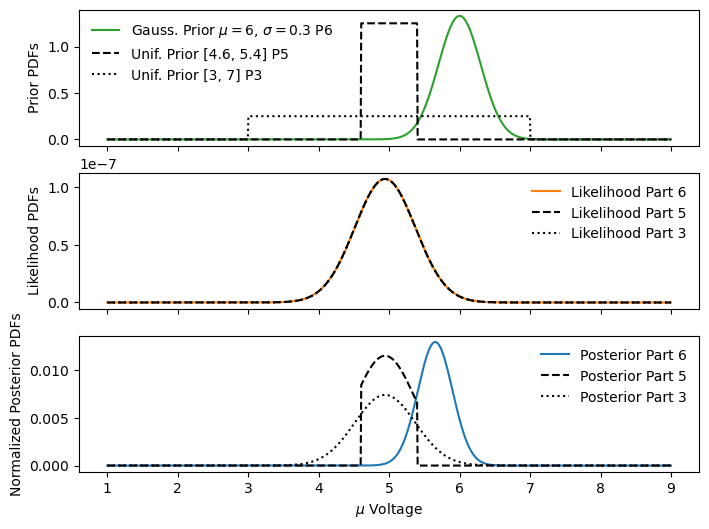

For Part 6              Lower Bound          Upper Bound
68.3% credible region:  5.404404404404405    5.892892892892893
Sample Mean ± error:    4.511874868373253    5.372361560477355
 
MAP:  5.652652652652653


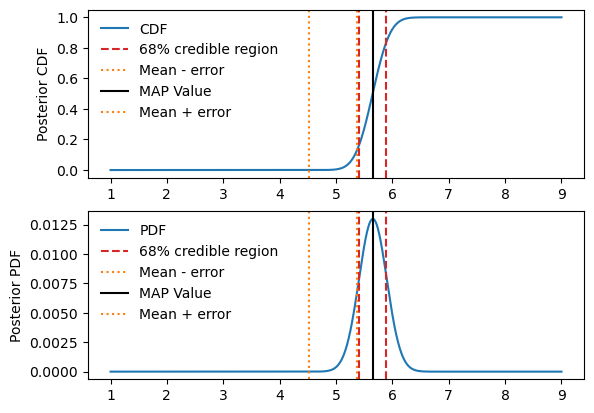

In [7]:
prior_p6 = [prior_funct(m, part6_prior=True) for m in mgrid]
likelihood_p6 = likelihood
post_p6 = [likelihood_funct(m, voltage, voltage_uncertainty) * prior_funct(m, part6_prior=True) for m in mgrid]
post_norm_p6 = post_p6/np.sum(post_p6)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)

ax[0].plot(mgrid, prior_p6, label=r'Gauss. Prior $\mu=6$, $\sigma=0.3$ P6', color='tab:green')
ax[0].plot(mgrid, prior_p5, label='Unif. Prior [4.6, 5.4] P5', color='black', ls='--')
ax[0].plot(mgrid, prior, label='Unif. Prior [3, 7] P3', color='black', ls=':')
ax[0].legend(frameon=False)
ax[0].set_ylabel('Prior PDFs')

ax[1].plot(mgrid, likelihood_p6, label='Likelihood Part 6', color='tab:orange')
ax[1].plot(mgrid, likelihood_p5, label='Likelihood Part 5', color='black', ls='--')
ax[1].plot(mgrid, likelihood, label='Likelihood Part 3', color='black', ls=':')
ax[1].legend(frameon=False)
ax[1].set_ylabel('Likelihood PDFs')

ax[2].plot(mgrid, post_norm_p6, label='Posterior Part 6', color='tab:blue')
ax[2].plot(mgrid, post_norm_p5, label='Posterior Part 5', color='black', ls='--')
ax[2].plot(mgrid, post_norm, label='Posterior Part 3', color='black', ls=':')
ax[2].legend(frameon=False)
ax[2].set_xlabel(r'$\mu$ Voltage')
ax[2].set_ylabel('Normalized Posterior PDFs')
#plt.plot(mgrid, prior)

plt.show()


###########################################################################


cdf_sorted_p6 = create_cdf(pdf=post_norm_p6, sort=True)
lower_bound_p6, upper_bound_p6 = get_cred_region(cr=0.683, cdf=cdf_sorted_p6, xgrid=mgrid)

# MAP
map_value_p6 = mgrid[np.argmax(post_norm_p6)]

print("For Part 6              Lower Bound", "         Upper Bound")
print("68.3% credible region: ", lower_bound_p6, "  ", upper_bound_p6)
print("Sample Mean ± error:   ", voltage_mean-voltage_mean_uncertainty, "  ", voltage_mean+voltage_mean_uncertainty)
print(" ")
print("MAP: ", map_value_p6)


fig, [ax, ax1] = plt.subplots(nrows=2, ncols=1)

ax.plot(mgrid, cdf_sorted_p6, label='CDF', color='tab:blue')
ax.axvline(lower_bound_p6, color='tab:red', ls='--', label=r'68% credible region')
ax.axvline(voltage_mean-voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean - error')
ax.axvline(map_value_p6, color='black', label='MAP Value')
ax.axvline(upper_bound_p6, color='tab:red', ls='--')
ax.axvline(voltage_mean+voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean + error')
ax.legend(frameon=False)
ax.set_ylabel('Posterior CDF')

ax1.plot(mgrid, post_norm_p6, label='PDF', color='tab:blue')
ax1.axvline(lower_bound_p6, color='tab:red', ls='--', label=r'68% credible region')
ax1.axvline(voltage_mean-voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean - error')
ax1.axvline(map_value_p6, color='black', label='MAP Value')
ax1.axvline(upper_bound_p6, color='tab:red', ls='--')
ax1.axvline(voltage_mean+voltage_mean_uncertainty, color='tab:orange', ls=':', label=r'Mean + error')
ax1.legend(frameon=False)
ax1.set_ylabel('Posterior PDF')

plt.show()

#### Part 7

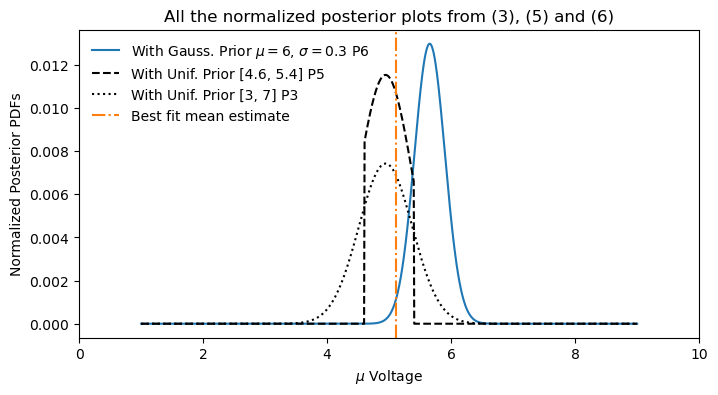

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

ax.plot(mgrid, post_norm_p6, label=r'With Gauss. Prior $\mu=6$, $\sigma=0.3$ P6', color='tab:blue')
ax.plot(mgrid, post_norm_p5, label='With Unif. Prior [4.6, 5.4] P5', color='black', ls='--')
ax.plot(mgrid, post_norm, label='With Unif. Prior [3, 7] P3', color='black', ls=':')
ax.axvline(beta_gauss[0], label='Best fit mean estimate', color='tab:orange', ls='-.')
ax.legend(frameon=False)
ax.set_xlabel(r'$\mu$ Voltage')
ax.set_ylabel('Normalized Posterior PDFs')
ax.set_xlim(0,10)
ax.set_title("All the normalized posterior plots from (3), (5) and (6)")

plt.show()

#### Part 8

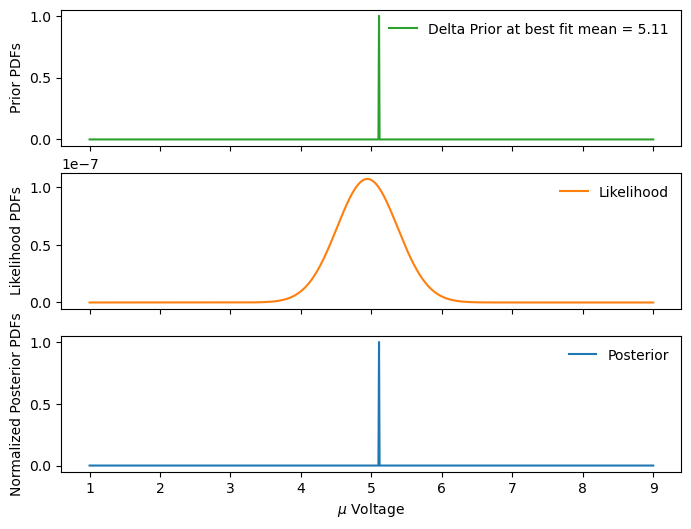

The Bayes Factor (B) of Part 3 (gaussian prior [3,7]) to Part 8 (delta prior):  0.2904448783856042
The ln(B) of  -1.2363414680762244  favors the model with Delta Function Prior.
This suggests that the model with Gaussian prior does experience Occam Penalty because according to the data, it appears to add complexity as compared to knowing mean exactly.


In [9]:
prior_p8 = [prior_funct(m, part8_prior=True) for m in mgrid]
likelihood_p8 = likelihood
post_p8 = [likelihood_funct(m, voltage, voltage_uncertainty) * prior_funct(m, part8_prior=True) for m in mgrid]
post_norm_p8 = post_p8/np.sum(post_p8)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)

ax[0].plot(mgrid, prior_p8, label=r'Delta Prior at best fit mean = %.2f' % round(beta_gauss[0], 2), color='tab:green')
ax[0].legend(frameon=False, loc=1)
ax[0].set_ylabel('Prior PDFs')

ax[1].plot(mgrid, likelihood_p8, label='Likelihood', color='tab:orange')
ax[1].legend(frameon=False)
ax[1].set_ylabel('Likelihood PDFs')

ax[2].plot(mgrid, post_norm_p8, label='Posterior', color='tab:blue')
ax[2].legend(frameon=False)
ax[2].set_xlabel(r'$\mu$ Voltage')
ax[2].set_ylabel('Normalized Posterior PDFs')
#plt.plot(mgrid, prior)

plt.show()


BF = np.trapz(post, mgrid)/np.sum(post_p8)#(np.sum(post)*(mgrid[1]-mgrid[0]))/np.sum(post_p8)

print("The Bayes Factor (B) of Part 3 (gaussian prior [3,7]) to Part 8 (delta prior): ", BF)

if np.log(BF)<0:
    print("The ln(B) of ", np.log(BF), " favors the model with Delta Function Prior.")
    
elif 2.3<=np.log(BF)<3.4:
    print("The ln(B) of ", np.log(BF), " strongly favors the model with Gaussian Prior [3, 7]")

elif 3.4<=np.log(BF)<4.6:
    print("The ln(B) of ", np.log(BF), " very strongly favors the model with Gaussian Prior [3, 7]")


print("This suggests that the model with Gaussian prior does experience Occam Penalty because according to the data, it appears to add complexity as compared to knowing mean exactly.")
#print("This suggests that the model with Gaussian Prior does not experience large Occam Penalty. Although Occam's razor penalizes a more complex model, which in this case is the Gaussian Prior, the large Baye's factor in its favour tells us that it provides a much better fit to the data than the simpler model (which was the delta function prior).")
      

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [10]:
import scipy

#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

#### Part 1

In [11]:
data_Q2 = np.load('../../../homeworks/hw_data/hw4_data_2.npy')

x, y, sigma_y = data_Q2

#### Part 2

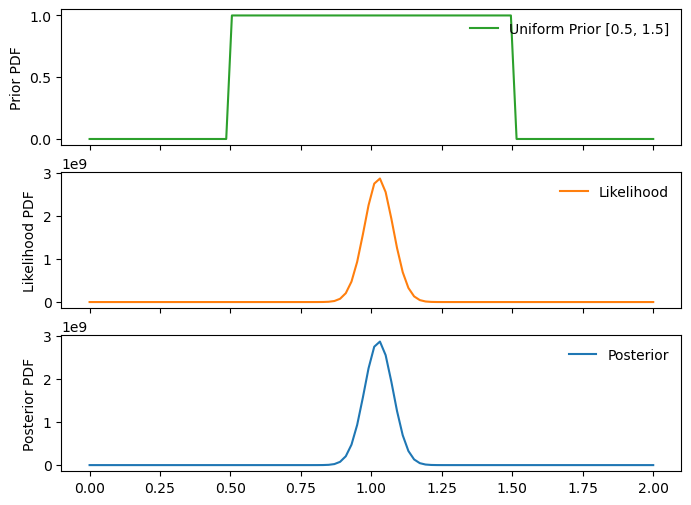

In [12]:
def prior_func_Q2(theta, part2=False, part4=False):

    if part2:
        
        if theta>=0.5 and theta<=1.5: #0.5<=theta<=1.5:
            return 1.0/(1.5-0.5)
        else:
            return 0

    elif part4:
        
        if theta>=-1 and theta<=0.25:
            return 1.0/(0.25-(-1))
        else:
            return 0

    else:
        raise ValueError("Specify which part's prior do you require!!!")
    
    
theta_grid = np.linspace(0, 2, 100)

prior_Q2 = [prior_func_Q2(tg, part2=True) for tg in theta_grid]
likelihood_Q2 = [np.exp(logL([-0.23, tg], data_Q2)) for tg in theta_grid]
post_Q2 = [np.exp(logL([-0.23, tg], data_Q2)) * prior_func_Q2(tg, part2=True) for tg in theta_grid]


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,6), sharex=True)

ax[0].plot(theta_grid, prior_Q2, label=r'Uniform Prior [0.5, 1.5]', color='tab:green')
ax[0].legend(frameon=False, loc=1)
ax[0].set_ylabel('Prior PDF')

ax[1].plot(theta_grid, likelihood_Q2, label='Likelihood', color='tab:orange')
ax[1].legend(frameon=False)
ax[1].set_ylabel('Likelihood PDF')

ax[2].plot(theta_grid, post_Q2, label='Posterior', color='tab:blue')
ax[2].legend(frameon=False)
ax[2].set_ylabel('Posterior PDF')


plt.show()

#### Part 3

In [13]:
evidence_mod1_Q2 = np.sum(post_Q2) * (theta_grid[1]-theta_grid[0])

print("The Bayesian evidence of this linear model is: ", evidence_mod1_Q2)

The Bayesian evidence of this linear model is:  365684733.1606595


#### Part 4

In [14]:
theta_grid = np.linspace(0, 2, 100)
theta_grid2 = np.linspace(-1.5, 0.75, 100)

theta_grid2d_1, theta_grid2d_2 = np.meshgrid(theta_grid, theta_grid2)

prior_Q2_2 = [prior_func_Q2(tg, part4=True) for tg in theta_grid2]

post_Q2_quad = np.zeros((100, 100))

for i in range(len(theta_grid2d_1)):
    for j in range(len(theta_grid2d_2)):

        ln_lik = logL([-0.23, theta_grid2d_1[i][j], theta_grid2d_2[i][j]], data_Q2)
        post_Q2_quad[i][j] = np.exp(ln_lik) * prior_func_Q2(theta_grid2d_1[i][j], part2=True) * prior_func_Q2(theta_grid2d_2[i][j], part4=True)


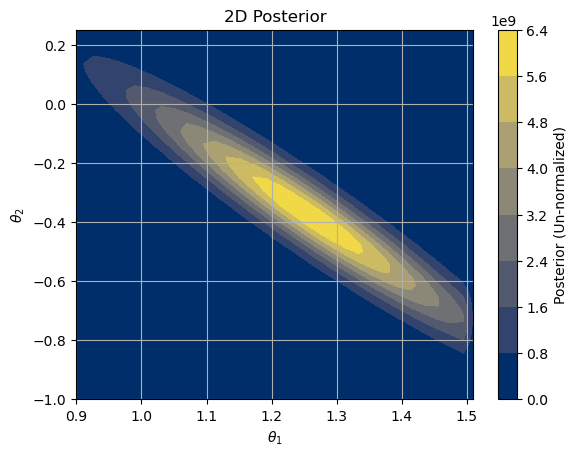

In [15]:
hist2d = plt.contourf(theta_grid2d_1, theta_grid2d_2, post_Q2_quad, cmap='cividis')
plt.colorbar(hist2d, label='Posterior (Un-normalized)')
plt.grid(True)
plt.xlim(0.9, 1.51)
plt.ylim(-1, 0.25)
plt.xlabel(r'$\theta_{1}$')
plt.ylabel(r'$\theta_{2}$')
plt.title("2D Posterior")
plt.show()

#### Part 5

In [16]:
evidence_mod2_Q2 = np.sum(post_Q2_quad) * (theta_grid[1]-theta_grid[0]) * (theta_grid2[1]-theta_grid2[0])

print("The Bayesian evidence of this linear model is: ", evidence_mod2_Q2)


The Bayesian evidence of this linear model is:  493339495.45811105


#### Part 6

In [17]:
print("The Bayes factor for a linear versus quadratic model: ", evidence_mod1_Q2/evidence_mod2_Q2)
print("The BIC comparison of these models gives:             ", 17.31/18.45)

The Bayes factor for a linear versus quadratic model:  0.7412435787673711
The BIC comparison of these models gives:              0.9382113821138212
